# Method of Manufactured Solutions (MMS) for incompressible Stoke's flow

## Test additional terms in conservation of momentum and mass

Two-dimensional, compressible, bottom heated, steady isoviscous thermal convection in a 1 x 1 box, see case 1 of [King et al. (2009)](https://doi.org/10.1111/j.1365-246X.2009.04413.x) / [Blankenbach et al. (1989) benchmark](https://academic.oup.com/gji/article/98/1/23/622167).

Keywords: Truncated Anelastic Liquid Approximation, TALA, Convection


In [1]:
import petsc4py
from petsc4py import PETSc

import underworld3 as uw
from underworld3.systems import Stokes
from underworld3 import function

import os 
import numpy as np
import sympy
from sympy.vector import gradient, divergence, dot

### Set parameters to use 

In [2]:
# this isa different k
k = 1.0 #### diffusivity

boxLength = 1.0
boxHeight = 1.0
tempMin   = 0.
tempMax   = 1.
deltaTemp = tempMax - tempMin

viscosity = 1

res = 128             ### x and y res of box
nsteps = 100        ### maximum number of time steps to run the first model 
epsilon_lr = 1e-8   ### criteria for early stopping; relative change of the Vrms in between iterations  

use_case = 1
sdev = 0.075 # standard deviation of Gaussian filter

# if set to 0 - incompressible material
# if set to 1 - compressible material


### Use sympy to calculate some of the source field terms

In [3]:
import sympy 
from sympy.vector import CoordSys3D, Del, divergence
from sympy.abc import x,z, sigma 

C = CoordSys3D('C')

# define theoretical velocity
vx = -(C.z - 0.5)*sympy.exp(-((C.x - 0.5)**2 + (C.z - 0.5)**2)/(2*sigma**2))
vz = (C.x - 0.5)*sympy.exp(-((C.x - 0.5)**2 + (C.z - 0.5)**2)/(2*sigma**2))
v_vec = vx*C.i + vz*C.k 

divergence(v_vec)

(0.5 - C.z)*(1.0 - 2*C.x)*exp((-(C.x - 0.5)**2 - (C.z - 0.5)**2)/(2*sigma**2))/(2*sigma**2) + (1.0 - 2*C.z)*(C.x - 0.5)*exp((-(C.x - 0.5)**2 - (C.z - 0.5)**2)/(2*sigma**2))/(2*sigma**2)

### Components of the strain tensor

In [4]:
u11 = 2*sympy.diff(vx, C.x)
u11

(0.5 - C.z)*(1.0 - 2*C.x)*exp((-(C.x - 0.5)**2 - (C.z - 0.5)**2)/(2*sigma**2))/sigma**2

In [5]:
u22 = 2*sympy.diff(vz, C.z)
u22

(1.0 - 2*C.z)*(C.x - 0.5)*exp((-(C.x - 0.5)**2 - (C.z - 0.5)**2)/(2*sigma**2))/sigma**2

In [6]:
u12 = sympy.diff(vx, C.z) + sympy.diff(vz, C.x)
u12

(0.5 - C.z)*(1.0 - 2*C.z)*exp((-(C.x - 0.5)**2 - (C.z - 0.5)**2)/(2*sigma**2))/(2*sigma**2) + (1.0 - 2*C.x)*(C.x - 0.5)*exp((-(C.x - 0.5)**2 - (C.z - 0.5)**2)/(2*sigma**2))/(2*sigma**2)

In [7]:
u21 = sympy.diff(vz, C.x) + sympy.diff(vx, C.z)
u21

(0.5 - C.z)*(1.0 - 2*C.z)*exp((-(C.x - 0.5)**2 - (C.z - 0.5)**2)/(2*sigma**2))/(2*sigma**2) + (1.0 - 2*C.x)*(C.x - 0.5)*exp((-(C.x - 0.5)**2 - (C.z - 0.5)**2)/(2*sigma**2))/(2*sigma**2)

In [8]:
col1 = u11*C.i + u21*C.k
sympy.simplify(divergence(col1))

(sigma**2*(16*C.z - 8.0) + (4.0 - 8*C.z)*(C.x - 0.5)**2 + (C.x - 0.5)*(2*C.x - 1.0)*(2*C.z - 1.0) - 4*(C.z - 0.5)**3)*exp(-((C.x - 0.5)**2 + (C.z - 0.5)**2)/(2*sigma**2))/(4*sigma**4)

In [9]:
col2 = u12*C.i + u22*C.k
sympy.simplify(divergence(col2))

(sigma**2*(8.0 - 16*C.x) + 4*(C.x - 0.5)**3 - (2*C.x - 1.0)*(C.z - 0.5)*(2*C.z - 1.0) + (8*C.x - 4.0)*(C.z - 0.5)**2)*exp(-((C.x - 0.5)**2 + (C.z - 0.5)**2)/(2*sigma**2))/(4*sigma**4)

In [10]:
# check the mesh if in a notebook / serial
# allows you to visualise the mesh and the mesh variable
'''FIXME: change this so it's better'''

def plotFig(meshbox, s_field, v_field, s_field_name, save_fname = None, with_arrows = False): 
    """
    s_field - scalar field - corresponds to colors
    v_field - vector field - usually the velocity - 2 components
    """
    if uw.mpi.size == 1:

        import numpy as np
        import pyvista as pv
        import vtk

        pv.global_theme.background = "white"
        pv.global_theme.window_size = [400, 400]
        pv.global_theme.anti_aliasing = None #"ssaa", "msaa", "fxaa", or None
        #pv.global_theme.jupyter_backend = "panel"
        pv.global_theme.smooth_shading = True

        meshbox.vtk("tmp_box_mesh.vtk")
        pvmesh = pv.read("tmp_box_mesh.vtk")

        velocity = np.zeros((meshbox.data.shape[0], 3))
        velocity[:, 0] = uw.function.evaluate(v_field.sym[0], meshbox.data)
        velocity[:, 1] = uw.function.evaluate(v_field.sym[1], meshbox.data)

        #pvmesh.point_data["V"] = velocity / 10

        points = np.zeros((s_field.coords.shape[0], 3))
        points[:, 0] = s_field.coords[:, 0]
        points[:, 1] = s_field.coords[:, 1]

        point_cloud = pv.PolyData(points)

        with meshbox.access():
            point_cloud.point_data[s_field_name] = uw.function.evaluate(s_field.fn, points[:, 0:2])

        # point sources at cell centres
        if meshbox._centroids.shape[0]%4 == 0:
            skip = 4
        elif meshbox._centroids.shape[0]%3 == 0:
            skip = 3
        elif meshbox._centroids.shape[0]%2 == 0:
            skip = 2
        else: 
            skip = 1

        cpoints = np.zeros((meshbox._centroids.shape[0] // skip, 3))
        cpoints[:, 0] = meshbox._centroids[::skip, 0]
        cpoints[:, 1] = meshbox._centroids[::skip, 1]

        cpoint_cloud = pv.PolyData(cpoints)

        # pvstream = pvmesh.streamlines_from_source(
        #     cpoint_cloud,
        #     vectors="V",
        #     integrator_type=2,
        #     integration_direction="forward",
        #     compute_vorticity=False,
        #     max_steps=1000,
        #     surface_streamlines=True,
        # )
 
        pl = pv.Plotter()

        with meshbox.access():
        
            arrow_loc = np.zeros((v_field.coords.shape[0], 3))
            arrow_loc[:, 0:2] = v_field.coords[...]

            arrow_length = np.zeros((v_field.coords.shape[0], 3))
            arrow_length[:, 0] = v_field.data[:, 0]
            arrow_length[:, 1] = v_field.data[:, 1]

        pl = pv.Plotter()

        #pl.add_mesh(pvmesh,'Gray', 'wireframe')

        pl.add_mesh(
            pvmesh, cmap="coolwarm", edge_color="Black",
            show_edges=True, use_transparency=False, opacity=0.2,
        )

      
        if with_arrows:
            pl.add_arrows(arrow_loc, arrow_length, mag=1, opacity=1)
        else:
            pl.add_points(point_cloud, cmap="coolwarm", render_points_as_spheres=True, point_size=6, opacity=1)


        # pl.add_mesh(pvstream, opacity=0.5)
        # pl.add_arrows(arrow_loc2, arrow_length2, mag=1.0e-1)

        # pl.add_points(pdata)

        pl.show(cpos="xy")

        if save_fname is not None:
            #pl.save_graphic(save_fname, dpi = 300)
            pl.image_scale = 3
            pl.screenshot(save_fname) 

        pvmesh.clear_data()
        pvmesh.clear_point_data()
        
        
#plotFig()

### Create mesh and variables

In [11]:
meshbox = uw.meshing.UnstructuredSimplexBox(
                                                minCoords=(0.0, 0.0), 
                                                maxCoords=(boxLength, boxHeight), 
                                                cellSize=1.0 /res, 
                                                regular=False, 
                                                qdegree = 3
                                        )

x, z = meshbox.X
#meshbox = uw.meshing.StructuredQuadBox(minCoords=(0.0, 0.0), maxCoords=(boxLength, boxHeight),  elementRes=(res,res))

# the reference curves are prepared here
# we follow the reference and set z = 0 to be the upper surface and z = 1 to be the lower surface
# this means that z = 0 is set at total temperature of 0 while z = 1 is set to total temp = 1
# we just need to reverse this during plotting


Processing gmsh file .meshes/uw_simplexbox_minC(0.0, 0.0)_maxC(1.0, 1.0)_csize0.0078125_regFalse.msh
Mesh saved to .meshes/uw_simplexbox_minC(0.0, 0.0)_maxC(1.0, 1.0)_csize0.0078125_regFalse.msh.h5


In [12]:
# the non-dimensionalized reference states are defined here
# formulations from King et al. and Davies et al.  
x, z = meshbox.X
#rho_bar = sympy.exp(rho_k*z) # rho_k is a positive number

In [13]:
v_soln = uw.discretisation.MeshVariable("U", meshbox, meshbox.dim, degree=2)
p_soln = uw.discretisation.MeshVariable("P", meshbox, 1, degree=1)
dpdx_soln = uw.discretisation.MeshVariable("Px", meshbox, 1, degree=1)
dpdz_soln = uw.discretisation.MeshVariable("Pz", meshbox, 1, degree=1)

v_analytical = uw.discretisation.MeshVariable("U2", meshbox, meshbox.dim, degree=2)
p_analytical = uw.discretisation.MeshVariable("P2", meshbox, 1, degree=1)
dpdx_analytical = uw.discretisation.MeshVariable("P2x", meshbox, 1, degree=1)
dpdz_analytical = uw.discretisation.MeshVariable("P2z", meshbox, 1, degree=1)

vx_diff = uw.discretisation.MeshVariable("Uxd", meshbox, 1, degree=2)
vz_diff = uw.discretisation.MeshVariable("Uzd", meshbox, 1, degree=2)
p_diff = uw.discretisation.MeshVariable("Pdiff", meshbox, 1, degree=1)
dpdx_diff = uw.discretisation.MeshVariable("Pdiffx", meshbox, 1, degree=1)
dpdz_diff = uw.discretisation.MeshVariable("Pdiffz", meshbox, 1, degree=1)

# for calculating the source field (body force)
Sx = uw.discretisation.MeshVariable("Sx", meshbox, 1, degree = 2) # how to do not scalar?
Sz = uw.discretisation.MeshVariable("Sz", meshbox, 1, degree = 2)

strain_rate = v_analytical.jacobian() + v_analytical.jacobian().T # the strain rate tensor in terms of the velocities

# for calculating difference
vx_diff_calc = uw.systems.Projection(meshbox, vx_diff)
vx_diff_calc.uw_function = v_analytical.sym[0] - v_soln.sym[0]

vz_diff_calc = uw.systems.Projection(meshbox, vz_diff)
vz_diff_calc.uw_function = v_analytical.sym[1] - v_soln.sym[1] 

p_diff_calc = uw.systems.Projection(meshbox, p_diff)
p_diff_calc.uw_function = p_analytical.fn - p_soln.fn

# pressure gradients calculator
dpdx_calc = uw.systems.Projection(meshbox, dpdx_soln)
dpdx_calc.uw_function = p_soln.sym.diff(x)[0]

dpdz_calc = uw.systems.Projection(meshbox, dpdz_soln)
dpdz_calc.uw_function = p_soln.sym.diff(z)[0]

# difference between pressure gradients
dpdx_diff_calc = uw.systems.Projection(meshbox, dpdx_diff)
dpdx_diff_calc.uw_function = dpdx_analytical.sym[0] - dpdx_soln.sym[0]

dpdz_diff_calc = uw.systems.Projection(meshbox, dpdz_diff)
dpdz_diff_calc.uw_function = dpdz_analytical.sym[0] - dpdz_soln.sym[0] 

### Stokes test (compressible material)
We set the conservation of mass as: 
\begin{aligned}
\nabla \cdot (\bar \rho \vec u) = \nabla \cdot \vec u + \frac{1}{\bar \rho} \vec u \cdot \nabla \bar \rho = 0. \; \; \; (1)
\end{aligned}
While the conservation of momentum is: 
\begin{aligned}
\nabla \cdot [\eta (\nabla \vec u + \nabla \vec u^T - \frac{2}{3}\nabla \cdot \vec u \bold{I})] - \nabla p + S= 0. \; \; \; (2)
\end{aligned}

For the method of manufactured solutions, we first look at (1). For TALA, the (non-dimensionalized) reference density is an exponential function of the form: $\bar \rho (z) = exp(kz)$. We use the same $\bar \rho (z)$ in this MMS test. Consequently, the gradient of the density is  $\nabla \bar \rho = k \bar \rho \bold{ \hat e_z}$. Eq. (1) becomes
\begin{aligned}
\nabla \cdot \vec u + \frac{1}{\bar \rho} \vec u \cdot \nabla \bar \rho = \nabla \cdot \vec u + k u_z = 0 \; \; \; (3)
\end{aligned}
Expanding the divergence term:  
\begin{aligned}
\frac{\partial u_x}{\partial x} + \frac{\partial u_z}{\partial z} + k u_z = 0  \; \; \; (4)
\end{aligned}

A velocity field that satisfies this criteria is one where $\frac{\partial u_x}{\partial x} = -\frac{k}{2}u_z$ and $\frac{\partial u_z}{\partial z} = -\frac{k}{2}u_z$. <br> An ideal manufactured solution that follows this is:  
\begin{aligned}
u_x = -\frac{kx}{2}exp(-\frac{k}{2}z) \; \; \; \; \; u_z = exp(-\frac{k}{2}z). \; \; \; 
\end{aligned}
We set the velocity boundary conditions to:
\begin{aligned} 
top: u_x (z = 1) = \frac{-kx}{2}exp(\frac{-k}{2}) \; \; u_z(z = 1) = exp(\frac{-k}{2}) \\
bottom: u_x (z = 0) = \frac{-kx}{2} \; \; u_z(z = 0) = 1 \\
left: u_x (x = 0) = 0 \; \; u_z(x = 1) = exp(\frac{-kz}{2}) \\
right: u_x (x = 1) = \frac{-k}{2}exp(\frac{-kz}{2}) \; \; u_z(x = 1) = exp(\frac{-kz}{2})\\
\end{aligned}
The pressure field is set to: 
\begin{aligned}
p(x, z) = sin(\pi x)sin(\pi z).
\end{aligned}
This field was chosen in order to have 0 pressure at the boundaries.

From this velocity field and setting viscosity $\eta = 1$, we can calculate the source term, S, as: 
\begin{aligned}
S = -\nabla \cdot [(\nabla \vec u + \nabla \vec u^T - \frac{2}{3}\nabla \cdot \vec u \bold{I})] + \nabla p
\end{aligned}
Expanding the equation above, we get: 
\begin{aligned}
-\nabla \cdot 
\begin{bmatrix}
2u_{x,x} - \frac{2}{3}(u_{x, x} + u_{z,z }) & u_{x, z} + u_{z, x} \\
u_{x, z} + u_{z, x} & 2u_{z, z} - \frac{2}{3}(u_{x, x} + u_{z,z }) 
\end{bmatrix} + 
\begin{bmatrix}
\pi cos(\pi x)sin(\pi z) \\
\pi sin(\pi x)cos(\pi z)
\end{bmatrix} = S
\end{aligned}

Solving the tensor divergence in the equation above and expressing it in terms of $u_z$:
\begin{aligned}
\begin{bmatrix}
\frac{k^3x}{8} u_z \\
-\frac{k^2}{4} u_z -\frac{k^2}{6} u_z
\end{bmatrix} + 
\begin{bmatrix}
\pi cos(\pi x)sin(\pi z) \\
\pi sin(\pi x)cos(\pi z)
\end{bmatrix} = S
\end{aligned}
 

In [14]:
# calculate the theoretical velocity, pressure, and source
import math 

def gaussian2d (x, z, sdev = 0.1):
    ''' Normalizing factor is 1 so integral of Gaussian is not 1'''
    expo = (x**2 + z**2)/(2*sdev**2)
    return math.exp(-expo)

with meshbox.access(v_analytical, p_analytical, dpdx_analytical, dpdz_analytical, Sx, Sz):
    for index, coord in enumerate(v_analytical.coords):
        x_val = coord[0] - 0.5
        z_val = coord[1] - 0.5

        v_analytical.data[index, 0] = -z_val*gaussian2d(x_val, z_val, sdev)
        v_analytical.data[index, 1] = x_val*gaussian2d(x_val, z_val, sdev)

    for index, coord in enumerate(p_analytical.coords):
        p_analytical.data[index] = math.sin(math.pi*coord[0])*math.sin(math.pi*coord[1])

    for index, coord in enumerate(Sx.coords):
        x_val = coord[0]
        z_val = coord[1]
        Sx.data[index] = -((16*z_val - 8)*sdev**2                        \
                           + (4 - 8*z_val)*(x_val - 0.5)**2             \
                           + (x_val - 0.5)*(2*x_val - 1)*(2*z_val - 1)  \
                           -4*(z_val - 0.5)**3                          \
                          )*gaussian2d(x_val - 0.5, z_val - 0.5, sdev)/(4*sdev**4) \
                        + math.pi*math.cos(math.pi*coord[0])*math.sin(math.pi*coord[1]) 
    
    for index, coord in enumerate(Sz.coords):
        x_val = coord[0]
        z_val = coord[1]
        Sz.data[index] = -((8 - 16*x_val)*sdev**2                        \
                            +(8*x_val - 4)*(z_val - 0.5)**2             \
                            -(z_val - 0.5)*(2*x_val - 1)*(2*z_val - 1)  \
                           + 4*(x_val - 0.5)**3                          \
                          )*gaussian2d(x_val - 0.5, z_val - 0.5, sdev)/(4*sdev**4) \
                        +math.pi*math.sin(math.pi*coord[0])*math.cos(math.pi*coord[1]) 
        
    # theoretical pressure gradients
    for index, coord in enumerate(dpdx_analytical.coords):
        dpdx_analytical.data[index] =  math.pi*math.cos(math.pi*coord[0])*math.sin(math.pi*coord[1])

    for index, coord in enumerate(dpdz_analytical.coords):
        dpdz_analytical.data[index] =  math.pi*math.sin(math.pi*coord[0])*math.cos(math.pi*coord[1])
        

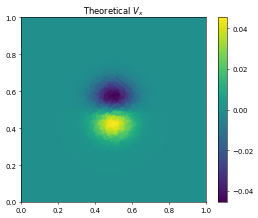

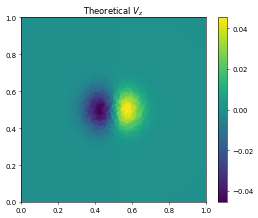

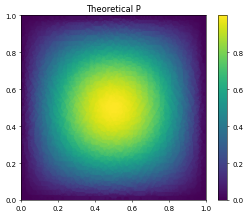

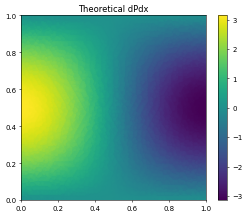

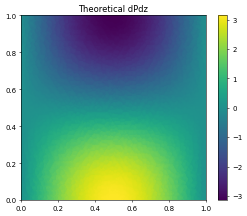

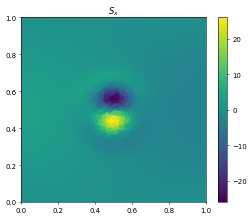

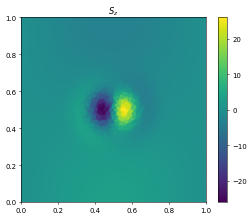

In [15]:
import matplotlib.pyplot as plt
with meshbox.access():
    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(v_analytical.coords[:, 0], v_analytical.coords[:, 1], c = v_analytical.data[:, 0], s = 20)
    ax.set_aspect("equal")
    ax.set_title(r"Theoretical $V_x$")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(v_analytical.coords[:, 0], v_analytical.coords[:, 1], c = v_analytical.data[:, 1], s = 20)
    ax.set_aspect("equal")
    ax.set_title(r"Theoretical $V_z$")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(p_analytical.coords[:, 0], p_analytical.coords[:, 1], c =p_analytical.data[:], s = 20)
    ax.set_aspect("equal")
    ax.set_title("Theoretical P")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(dpdx_analytical.coords[:, 0], dpdx_analytical.coords[:, 1], c =dpdx_analytical.data[:], s = 20)
    ax.set_aspect("equal")
    ax.set_title("Theoretical dPdx")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(dpdz_analytical.coords[:, 0], dpdz_analytical.coords[:, 1], c =dpdz_analytical.data[:], s = 20)
    ax.set_aspect("equal")
    ax.set_title("Theoretical dPdz")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(Sx.coords[:, 0], Sx.coords[:, 1], c =Sx.data[:], s = 20)
    ax.set_aspect("equal")
    ax.set_title(r"$S_x$")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(Sz.coords[:, 0], Sz.coords[:, 1], c =Sz.data[:], s = 20)
    ax.set_aspect("equal")
    ax.set_title(r"$S_z$")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)

In [16]:
# Create Stokes object

stokes = Stokes(
    meshbox,
    velocityField=v_soln,
    pressureField=p_soln,
    solver_name="stokes",
)
stokes.petsc_options["snes_type"] = "ksponly"
# stokes petsc parameters
# stokes.petsc_options["ksp_monitor"] = None
# stokes.petsc_options['pc_type'] = 'lu'
# stokes.petsc_options["snes_max_it"] = 1000

# stokes.petsc_options["snes_atol"] = 1e-6
# stokes.petsc_options["snes_rtol"] = 1e-6


#stokes.petsc_options["ksp_rtol"]  = 1e-5 # reduce tolerance to increase speed

# Set solve options here (or remove default values
# stokes.petsc_options.getAll()

#stokes.petsc_options["snes_rtol"] = 1.0e-6
# stokes.petsc_options["fieldsplit_pressure_ksp_monitor"] = None
# stokes.petsc_options["fieldsplit_velocity_ksp_monitor"] = None
# stokes.petsc_options["fieldsplit_pressure_ksp_rtol"] = 1.0e-6
# stokes.petsc_options["fieldsplit_velocity_ksp_rtol"] = 1.0e-2
# stokes.petsc_options.delValue("pc_use_amat")

# additional term in constitutive equation? 
stokes.constitutive_model = uw.systems.constitutive_models.ViscousFlowModel(meshbox.dim)
stokes.constitutive_model.Parameters.viscosity=viscosity 
# stokes.saddle_preconditioner = 1.0 / viscosity
# TODO: constitutive equation

# Free-slip boundary conditions
if use_case == 0: # incompressible
    # Free-slip boundary conditions
    stokes.add_dirichlet_bc((0.0,), "Left", (0,))
    stokes.add_dirichlet_bc((0.0,), "Right", (0,))
    stokes.add_dirichlet_bc((0.0,), "Top", (1,))
    stokes.add_dirichlet_bc((0.0,), "Bottom", (1,))
else:
    stokes.add_dirichlet_bc((0., 0.), "Left", (0, 1))
    stokes.add_dirichlet_bc((0., 0.), "Right", (0,1))
    stokes.add_dirichlet_bc((0., 0.), "Top", (0, 1))
    stokes.add_dirichlet_bc((0., 0.), "Bottom", (0, 1))

#buoyancy_force = Ra * t_soln.sym[0]
#buoyancy_force = 0
stokes.bodyforce = sympy.Matrix([Sx.sym[0], Sz.sym[0]])

# add terms into the conservation of mass according to the formulation in King et al 

# if use_case == 1:
#     stokes.PF0 = sympy.Matrix([dot(v_soln.fn, gradient(rho_bar))/rho_bar])
#     stokes.UF1 = (-2/3)*divergence(v_soln.fn) * sympy.eye(meshbox.dim)

stokes.stokes_problem_description() # FIXME: need to run this? 

In [17]:
# (-2/3)*divergence(v_soln.fn) * sympy.eye(meshbox.dim)

In [18]:
if use_case == 1: 
    # check the equations for the Stokes system
    display(stokes._p_f0) # LHS of c.o. mass 
    display(stokes._u_f1) # LHS of c.o. momentum
    display(stokes._u_f0) # RHS of c.o. momentum / buoyancy force

Matrix([[U_{ 0,0}(N0.x, N0.y) + U_{ 1,1}(N0.x, N0.y)]])

Matrix([
[    -P(N0.x, N0.y) + 2*U_{ 0,0}(N0.x, N0.y), U_{ 0,1}(N0.x, N0.y) + U_{ 1,0}(N0.x, N0.y)],
[U_{ 0,1}(N0.x, N0.y) + U_{ 1,0}(N0.x, N0.y),     -P(N0.x, N0.y) + 2*U_{ 1,1}(N0.x, N0.y)]])

Matrix([[-Sx(N0.x, N0.y), -Sz(N0.x, N0.y)]])

In [19]:
stokes.solve()

  0 SNES Function norm 0.0204411 
  1 SNES Function norm 1.06912e-09 
Nonlinear stokes_ solve converged due to CONVERGED_ITS iterations 1


5

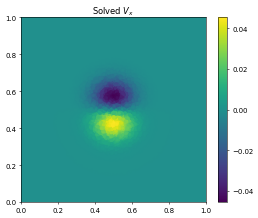

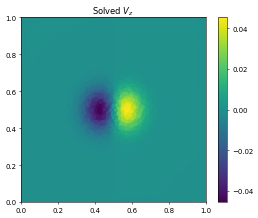

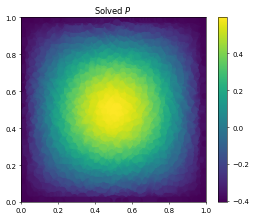

In [20]:
with meshbox.access():
    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(v_soln.coords[:, 0], v_soln.coords[:, 1], c = v_soln.data[:, 0], s = 15)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    ax.set_title(r"Solved $V_x$")

    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(v_soln.coords[:, 0], v_soln.coords[:, 1], c = v_soln.data[:, 1], s = 15)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    ax.set_title(r"Solved $V_z$")

    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(p_soln.coords[:, 0], p_soln.coords[:, 1], c = p_soln.data[:], s = 60)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    ax.set_title(r"Solved $P$")

In [21]:
vx_diff_calc.solve()
vz_diff_calc.solve()
p_diff_calc.solve()
dpdx_calc.solve()
dpdz_calc.solve()
dpdx_diff_calc.solve()
dpdz_diff_calc.solve()

  0 SNES Function norm 3.557e-11 
  1 SNES Function norm < 1.e-11
Nonlinear SProj_1_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 3.559e-11 
  1 SNES Function norm < 1.e-11
Nonlinear SProj_2_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 0.00293483 
  1 SNES Function norm 5.53925e-08 
Nonlinear SProj_3_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 0.0113693 
  1 SNES Function norm 1.47454e-07 
Nonlinear SProj_4_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 0.0113672 
  1 SNES Function norm 1.54966e-07 
Nonlinear SProj_5_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 1.31736e-06 
  1 SNES Function norm 2.782e-11 
Nonlinear SProj_6_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 1
  0 SNES Function norm 1.34307e-06 
  1 SNES Function norm 2.706e-11 
Nonlinear SProj_7_ solve converged du

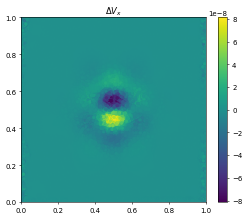

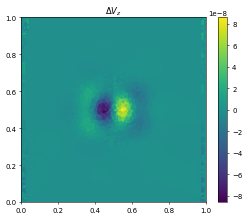

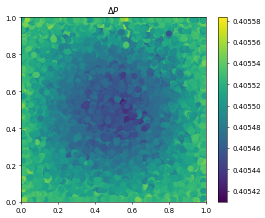

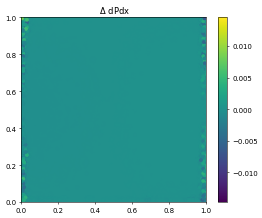

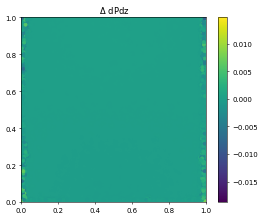

In [22]:
with meshbox.access():
    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(vx_diff.coords[:, 0], vx_diff.coords[:, 1], c = vx_diff.data[:], s = 15)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    ax.set_title(r"$\Delta V_x$")

    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(vz_diff.coords[:, 0], vz_diff.coords[:, 1], c = vz_diff.data[:], s = 15)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    ax.set_title(r"$\Delta V_z$")

    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(p_diff.coords[:, 0], p_diff.coords[:, 1], c = p_diff.data[:], s = 60)
    ax.set_aspect("equal")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    ax.set_title(r"$\Delta P$")

    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(dpdx_diff.coords[:, 0], dpdx_diff.coords[:, 1], c =dpdx_diff.data[:], s = 20)
    ax.set_aspect("equal")
    ax.set_title(r" $\Delta$ dPdx")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)
    
    fig, ax = plt.subplots(dpi = 50)
    out = ax.scatter(dpdz_diff.coords[:, 0], dpdz_diff.coords[:, 1], c =dpdz_diff.data[:], s = 20)
    ax.set_aspect("equal")
    ax.set_title(r" $\Delta$ dPdz")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.colorbar(out)

In [23]:
with meshbox.access():
    print(np.mean(p_diff.data))
    print(np.std(p_diff.data))
    print(np.mean(dpdx_diff.data))
    print(np.std(dpdz_diff.data))

0.40549681746143507
2.4530199681492584e-05
6.71875994162724e-07
0.0005749280712776414


In [24]:
# calculate the MSE
with meshbox.access():
    vx_mse = (vx_diff.data**2).mean()
    vz_mse = (vz_diff.data**2).mean()
    p_mse = (p_diff.data**2).mean()
    dpdx_mse = (dpdx_diff.data**2).mean()
    dpdz_mse = (dpdz_diff.data**2).mean()

print("Vx:", vx_mse)
print("Vz:", vz_mse)
print("P: ", p_mse)
print("dpdx: ", dpdx_mse)
print("dpdz: ", dpdz_mse)


Vx: 4.888756789456767e-17
Vz: 4.894016720211971e-17
P:  0.16442766957308308
dpdx:  4.494234581491208e-07
dpdz:  3.305422934847345e-07


ValueError: x and y must have same first dimension, but have shapes (8,) and (7,)

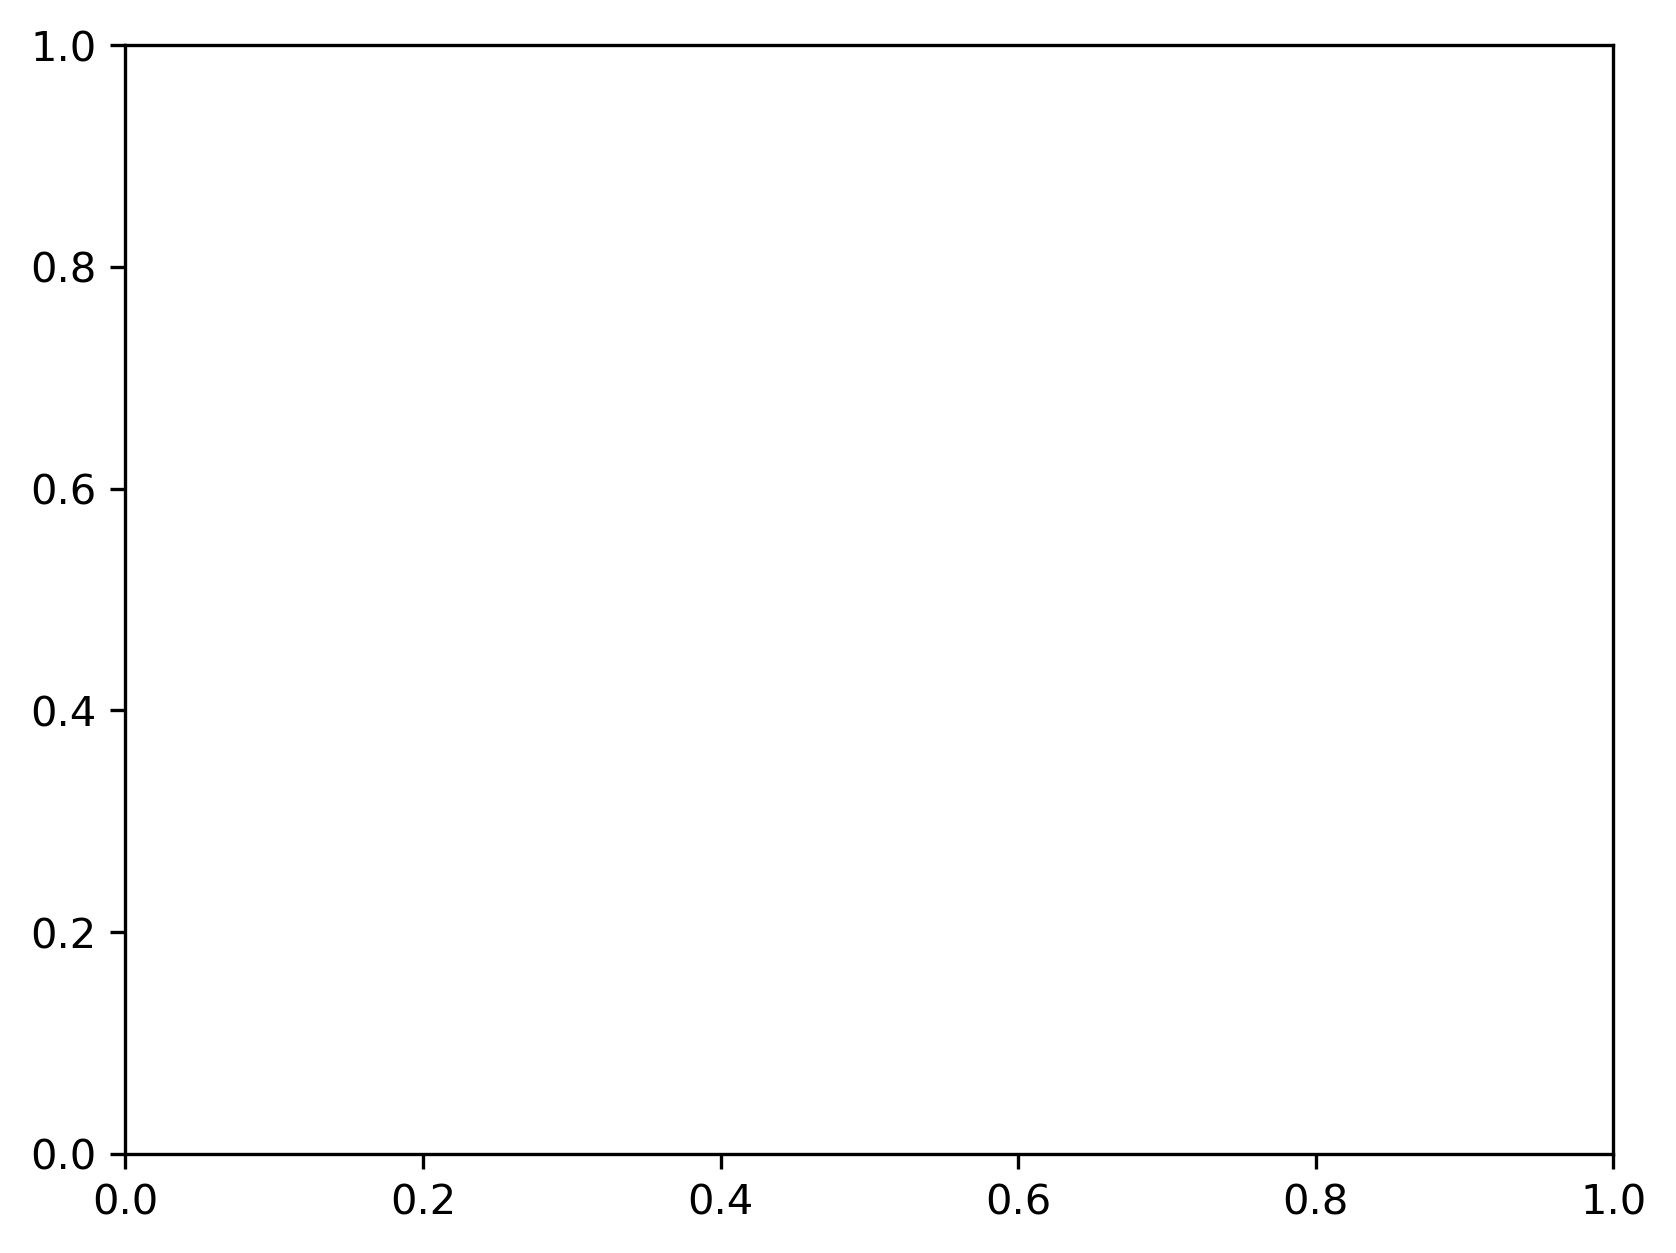

In [25]:
res_list = np.array([8, 16, 32, 48, 64, 80, 96, 128])

vx_mse_arr      = np.array([2.3638300335916266e-07, 6.279930864875772e-10, 2.958750220371032e-12, 1.1909425848489748e-13, 1.2206358068776717e-14, 2.083739540150276e-15, 4.907921538976699e-16, 4.888756789456767e-17])
vz_mse_arr      = np.array([2.3638300335916266e-07, 6.281745632620449e-10, 2.952687788760118e-12, 1.1900900103566036e-13, 1.2202595011941015e-14, 2.083925160465564e-15, 4.888821497950132e-16, 4.894016720211971e-17])
p_mse_arr       = np.array([0.16158532927594252, 0.16391683934634846, 0.16440903196372636, 0.16461085823397692, 0.16457711722231785, 0.164511398834713, 0.16439907268116363])
dpdx_mse_arr    = np.array([0.01501847684196666, 0.0007070075933034502, 6.284149883712916e-05, 1.2002183007508502e-05, 5.593377751763672e-06, 2.8771101389832342e-06, 1.8333660634181627e-06, 4.494234581491208e-07])
dpdz_mse_arr    = np.array([0.015064485709355264, 0.0006262734987514728, 6.0410385549941385e-05, 8.363408028428195e-06, 3.108836732964897e-06, 1.7919080818481336e-06, 1.6460836139490165e-06, 3.305422934847345e-07])

import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi = 300)
ax.plot(res_list, vx_mse_arr, linestyle = "dashed", color = "k", linewidth = 1, markersize = 2,label = r"$v_x$")
ax.plot(res_list, vz_mse_arr, linestyle = "solid", color = "k", linewidth = 1, markersize =2, label = r"$v_z$")
ax.plot(res_list, dpdx_mse_arr, linestyle = "dashdot", color = "k", linewidth = 1, markersize = 2,label = r"$\frac{\partial p}{\partial x}$")
ax.plot(res_list, dpdz_mse_arr, linestyle = "dotted", color = "k", linewidth = 1, markersize =2, label = r"$\frac{\partial p}{\partial z}$")
ax.set_xlabel("Resolution")
ax.set_ylabel(r"$v_{x, z}$ M.S.E.")
ax.set_yscale("log")
ax.set_xscale("log")

# share x only
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$P$ M.S.E.', color=color)  # we already handled the x-label with ax1
ax2.plot(res_list, p_mse_arr, "o-", color=color, linewidth = 1, markersize =2, label = r"$P$")
ax2.tick_params(axis='y', labelcolor=color)

# ask matplotlib for the plotted objects and their labels
# this is cool!
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=7)

# outfile = "/Users/jcgraciosa/Documents/codes/uw3-dev/King_benchmark/out_plots/mms_tala.png"
# plt.savefig(outfile)